## HURDAT2, Get Started!

In the following example we will walk through how we can leverage the `clouddrift` library to plot storm trajectories for the 2022 hurricane season.

Let's proceed with loading in the dataset and selecting the subset of data we want to plot.

In [1]:
# libraries import
import  numpy as np
import clouddrift as cd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
# Load the dataset for the Atlantic basin
ds = cd.datasets.hurdat2(basin="atlantic")
ds

<xarray.Dataset> Size: 9MB
Dimensions:                          (traj: 1951, obs: 53950)
Coordinates:
    id                               (traj) <U8 62kB ...
    time                             (obs) datetime64[ns] 432kB ...
Dimensions without coordinates: traj, obs
Data variables: (12/22)
    basin                            (traj) <U2 16kB ...
    year                             (traj) int64 16kB ...
    rowsize                          (traj) int64 16kB ...
    record_identifier                (obs) <U1 216kB ...
    system_status                    (obs) <U2 432kB ...
    lat                              (obs) float64 432kB ...
    ...                               ...
    max_med_wind_radius_nw           (obs) float64 432kB ...
    max_high_wind_radius_ne          (obs) float64 432kB ...
    max_high_wind_radius_se          (obs) float64 432kB ...
    max_high_wind_radius_sw          (obs) float64 432kB ...
    max_high_wind_radius_nw          (obs) float64 432kB ...
    max_sustained_wind_speed_radius  (obs) float64 432kB ...
Attributes:
    title:            HURricane DATa 2nd generation (HURDAT2)
    date_created:     2024-04-01T14:15:46.463623
    publisher_name:   NOAA AOML Hurricane Research Division
    publisher_email:  AOML.HRDWebmaster@noaa.gov
    publisher_url:    https://www.aoml.noaa.gov/hrd/hurdat/Data_Storm.html
    institution:      NOAA Atlantic Oceanographic and Meteorological Laboratory
    summary:          The National Hurricane Center (NHC) conducts a post-sto...

In [3]:
# Select the data for the year 2022 only by using the ragged.subset method
year = 2022
ds = cd.ragged.subset(
    ds,
    {"time": (np.datetime64(f"{year}-01-01"), np.datetime64(f"{year}-12-31"))},
    row_dim_name="traj",
)
ds

<xarray.Dataset> Size: 70kB
Dimensions:                          (traj: 15, obs: 445)
Coordinates:
    id                               (traj) <U8 480B 'AL012022' ... 'AL162022'
    time                             (obs) datetime64[ns] 4kB 2022-06-02T18:0...
Dimensions without coordinates: traj, obs
Data variables: (12/22)
    basin                            (traj) <U2 120B ...
    year                             (traj) int64 120B ...
    rowsize                          (traj) int64 120B 17 55 6 62 ... 18 24 21
    record_identifier                (obs) <U1 2kB ...
    system_status                    (obs) <U2 4kB ...
    lat                              (obs) float64 4kB ...
    ...                               ...
    max_med_wind_radius_nw           (obs) float64 4kB ...
    max_high_wind_radius_ne          (obs) float64 4kB ...
    max_high_wind_radius_se          (obs) float64 4kB ...
    max_high_wind_radius_sw          (obs) float64 4kB ...
    max_high_wind_radius_nw          (obs) float64 4kB ...
    max_sustained_wind_speed_radius  (obs) float64 4kB ...
Attributes:
    title:            HURricane DATa 2nd generation (HURDAT2)
    date_created:     2024-04-01T14:15:46.463623
    publisher_name:   NOAA AOML Hurricane Research Division
    publisher_email:  AOML.HRDWebmaster@noaa.gov
    publisher_url:    https://www.aoml.noaa.gov/hrd/hurdat/Data_Storm.html
    institution:      NOAA Atlantic Oceanographic and Meteorological Laboratory
    summary:          The National Hurricane Center (NHC) conducts a post-sto...

Let's now plot the trajectories using the `plot_ragged` function from the `plotting` utility module provided by `clouddrift`. It helps handle and abstract away having to extract each rows/trajectories segment in the lon/lat ragged array so that we can plot them.

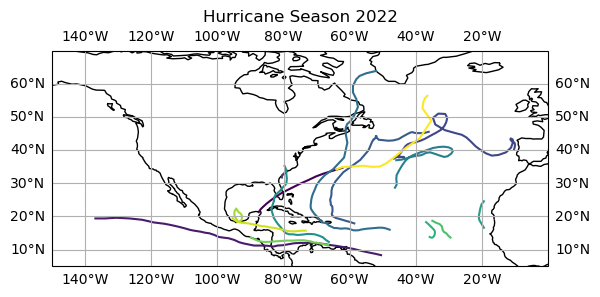

In [4]:
# make figure
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
hl = cd.plotting.plot_ragged(
    ax,
    ds.lon,
    ds.lat,
    ds.rowsize,
    transform=ccrs.PlateCarree(),
)
ax.set_extent([-150, 0, 5, 70], crs=ccrs.PlateCarree())
ax.set_title(f"Hurricane Season {year}")
ax.coastlines()
ax.gridlines(draw_labels=True)